---
title: Assignment 04
author:
  - name: Dominique Strong
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: today
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2

execute:
  echo: false
  eval: false
  freeze: auto
---

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/assignment-03-DomStrong11/data/lightcast_job_postings.csv")
# The data is not available in assignment-04 folder, so I used the full path to the data file.


# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/06 22:18:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---


25/10/06 22:19:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

In [2]:
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

eda_cols = [
    "Salary",
    "MIN_YEARS_EXPERIENCE",
    "MAX_YEARS_EXPERIENCE",
    "DURATION",
    "STATE_NAME",
    "CITY_NAME",
    "REMOTE_TYPE_NAME",
    "EMPLOYMENT_TYPE_NAME",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    "MIN_EDULEVELS_NAME",
]

df_eda = df.select(eda_cols)
df_eda.show(5, truncate=False)

+------+--------------------+--------------------+--------+----------+-------------+----------------+----------------------+-------------+-------------------+-------------------+
|Salary|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|STATE_NAME|CITY_NAME    |REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME  |IS_INTERNSHIP|COMPANY_IS_STAFFING|MIN_EDULEVELS_NAME |
+------+--------------------+--------------------+--------+----------+-------------+----------------+----------------------+-------------+-------------------+-------------------+
|NULL  |2                   |2                   |6       |Arkansas  |El Dorado, AR|[None]          |Full-time (> 32 hours)|false        |false              |Bachelor's degree  |
|NULL  |3                   |3                   |NULL    |Maine     |Augusta, ME  |Remote          |Full-time (> 32 hours)|false        |true               |No Education Listed|
|NULL  |5                   |NULL                |35      |Texas     |Dallas, TX   |[None]          |Full

In [3]:
from pyspark.sql.functions import col, sum as spark_sum, when, trim, length
import hvplot.pandas

missing_df = df_eda.select([
    spark_sum(
        when(col(c).isNull() | (length(trim(col(c))) == 0), 1).otherwise(0)).alias(c)
     for c in df_eda.columns
])

missing_pd = missing_df.toPandas().T.reset_index()
missing_pd.columns = ["column", "missing_count"]

total_rows = df_eda.count()
missing_pd["missing_pct"] = 100 * missing_pd["missing_count"] / total_rows

missing_pd.sort_values(by="missing_pct", ascending=False).hvplot.bar(
    x="column",
    y="missing_pct",
    title="Percentage of Missing Values by Column",
    rot=60,
    height=500,
    width=900,
    ylabel="Missing Percentage (%)",
    xlabel="Features"
).opts(xrotation=45)

:Bars   [column]   (missing_pct)

In [4]:
# Cleaning the Remote Type Name Column

df_eda = df_eda.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

categorical_cols = ["REMOTE_TYPE_NAME"]

for colname in categorical_cols:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----REMOTE_TYPE_NAME -----


+----------------+
|REMOTE_TYPE_NAME|
+----------------+
|Remote          |
|On Premise      |
|Hybrid          |
|Undefined       |
+----------------+



In [5]:
# Cleaning the State Name Column

cat_state_cols = ["STATE_NAME"]

for colname in cat_state_cols:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----STATE_NAME -----


+---------------------------------------+
|STATE_NAME                             |
+---------------------------------------+
|Utah                                   |
|Hawaii                                 |
|Minnesota                              |
|Ohio                                   |
|Arkansas                               |
|Oregon                                 |
|Texas                                  |
|North Dakota                           |
|Pennsylvania                           |
|Connecticut                            |
|Nebraska                               |
|Vermont                                |
|Nevada                                 |
|Washington                             |
|Illinois                               |
|Oklahoma                               |
|Delaware                               |
|Alaska                                 |
|New Mexico                             |
|West Virginia                          |
|Missouri                         

In [6]:
# Cleaning the Employee Type Name Column

df_eda = df_eda.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)

categorical_cols_emp = ["EMPLOYMENT_TYPE_NAME"]

for colname in categorical_cols_emp:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----EMPLOYMENT_TYPE_NAME -----


+--------------------+
|EMPLOYMENT_TYPE_NAME|
+--------------------+
|Flexible            |
|Fulltime            |
|Parttime            |
+--------------------+



In [7]:
# Cleaning the Company Is Staffing Column

df_eda = df_eda.withColumn(
    "COMPANY_IS_STAFFING",
    when(col("COMPANY_IS_STAFFING").isNull(), False)
    .otherwise(col("COMPANY_IS_STAFFING"))
)

categorical_cols_staff = ["COMPANY_IS_STAFFING"]

for colname in categorical_cols_staff:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----COMPANY_IS_STAFFING -----


+-------------------+
|COMPANY_IS_STAFFING|
+-------------------+
|true               |
|false              |
+-------------------+



In [8]:
# Cleaning the IS Internship Column

df_eda = df_eda.withColumn(
    "IS_INTERNSHIP",
    when(col("IS_INTERNSHIP").isNull(), False)
    .otherwise(col("IS_INTERNSHIP"))
)

categorical_cols_intern = ["IS_INTERNSHIP"]

for colname in categorical_cols_intern:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----IS_INTERNSHIP -----


+-------------+
|IS_INTERNSHIP|
+-------------+
|true         |
|false        |
+-------------+



In [9]:
from pyspark.sql import functions as F

# Replace missing durations with the median
# Calculate the median duration
# Replace missing experience values with the median
# Calculate the median experience

df_eda = df_eda.withColumn("DURATION", F.col("DURATION").cast("double")) \
               .withColumn("MAX_YEARS_EXPERIENCE", F.col("MAX_YEARS_EXPERIENCE").cast("double")) \

median_duration = df.approxQuantile("DURATION", [0.5], 0.01)[0]
median_exp = df.approxQuantile("MAX_YEARS_EXPERIENCE", [0.5], 0.01)[0]

df_eda = df_eda.withColumn(
    "DURATION",
    F.when(F.col("DURATION").isNull() | F.isnan("DURATION"), F.lit(median_duration))
     .otherwise(F.col("DURATION"))
).withColumn(
    "MAX_YEARS_EXPERIENCE",
    F.when(F.col("MAX_YEARS_EXPERIENCE").isNull() | F.isnan("MAX_YEARS_EXPERIENCE"), F.lit(median_exp))
     .otherwise(F.col("MAX_YEARS_EXPERIENCE"))
)

In [10]:
df_eda.show(5, truncate=False)

+------+--------------------+--------------------+--------+----------+-------------+----------------+--------------------+-------------+-------------------+-------------------+
|Salary|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|STATE_NAME|CITY_NAME    |REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME|IS_INTERNSHIP|COMPANY_IS_STAFFING|MIN_EDULEVELS_NAME |
+------+--------------------+--------------------+--------+----------+-------------+----------------+--------------------+-------------+-------------------+-------------------+
|NULL  |2                   |2.0                 |6.0     |Arkansas  |El Dorado, AR|Undefined       |Fulltime            |false        |false              |Bachelor's degree  |
|NULL  |3                   |3.0                 |18.0    |Maine     |Augusta, ME  |Remote          |Fulltime            |false        |true               |No Education Listed|
|NULL  |5                   |3.0                 |35.0    |Texas     |Dallas, TX   |Undefined       |Fulltime      

In [31]:
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, BooleanType, StringType

# Drop rows with NA values in relevant columns
regression_df = df_eda.dropna(subset=[
    "Salary",
    "MIN_YEARS_EXPERIENCE",
    "MAX_YEARS_EXPERIENCE",
    "STATE_NAME",
    "DURATION",
    "CITY_NAME",
])


# Categorical columns
categorical_cols = [
    "STATE_NAME",
    "EMPLOYMENT_TYPE_NAME",
]

regression_df = regression_df.withColumn("DURATION",col("DURATION").cast(IntegerType()))
regression_df.show(5, truncate=False)



+------+--------------------+--------------------+--------+----------+------------------+----------------+--------------------+-------------+-------------------+-------------------+
|Salary|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|STATE_NAME|CITY_NAME         |REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME|IS_INTERNSHIP|COMPANY_IS_STAFFING|MIN_EDULEVELS_NAME |
+------+--------------------+--------------------+--------+----------+------------------+----------------+--------------------+-------------+-------------------+-------------------+
|92962 |2                   |2.0                 |18      |New York  |New York, NY      |Undefined       |Fulltime            |false        |false              |Bachelor's degree  |
|107645|10                  |3.0                 |18      |California|Ridgecrest, CA    |On Premise      |Fulltime            |false        |false              |High school or GED |
|192800|6                   |3.0                 |55      |Michigan  |Detroit, MI       |U

Generalized Linear Regression Summary

Train a Linear Regression model using the training data

In [32]:
from pyspark.sql.functions import regexp_replace, trim

# Index and One-Hot Encode
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip')
    for col in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec")
    for col in categorical_cols
]

# Assemble base features (for GLR and Random Forest)
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "MAX_YEARS_EXPERIENCE",
        "DURATION",
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline.fit(regression_df).transform(regression_df)

regression_data.select("Salary", "features").show(5, truncate=False)

+------+------------------------------------------+
|Salary|features                                  |
+------+------------------------------------------+
|92962 |(55,[0,1,2,5,53],[2.0,2.0,18.0,1.0,1.0])  |
|107645|(55,[0,1,2,3,53],[10.0,3.0,18.0,1.0,1.0]) |
|192800|(55,[0,1,2,18,53],[6.0,3.0,55.0,1.0,1.0]) |
|125900|(55,[0,1,2,16,53],[12.0,3.0,18.0,1.0,1.0])|
|170000|(55,[0,1,2,3,53],[6.0,3.0,18.0,1.0,1.0])  |
+------+------------------------------------------+
only showing top 5 rows



In [33]:
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)

print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

(23697, 16)


(18966, 16)


(4731, 16)


In [34]:
#Linear Regression Model

from pyspark.ml.regression import GeneralizedLinearRegression

# Get feature names from assembler (optional)
feature_names = assembler.getInputCols()

# Initialize GLR model
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="Salary",
    family="gaussian",
    link="identity",   # standard linear regression
    maxIter=10,
    regParam=0.3
)

# Fit model on training data
glr_model = glr.fit(regression_train)

# Get summary
summary = glr_model.summary


In [35]:
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for name, coef in zip(feature_names, glr_model.coefficients):
    print(f"{name}: {coef:.2f}")
    
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])

Intercept: 68551.1077
Coefficients:
MIN_YEARS_EXPERIENCE: 6510.40
MAX_YEARS_EXPERIENCE: 1826.01
DURATION: -78.00
STATE_NAME_vec: 18690.64
EMPLOYMENT_TYPE_NAME_vec: 9576.45

--- Regression Summary ---


Coefficient Standard Errors: ['83.2698', '281.7201', '23.4734', '5634.0064', '5657.6730', '5683.4272', '5713.5493', '5727.0646', '5738.6676', '5780.3249', '5786.3712', '5784.6369', '5792.6863', '5819.1336', '5819.1019', '5838.5466', '5835.9090', '5842.9808', '5840.2923', '5877.8234', '5879.5533', '5891.8650', '5923.6434', '5967.1917', '5978.2357', '6010.4124', '6073.7981', '6075.7578', '6146.9697', '6166.3832', '6155.0823', '6157.7360', '6230.3753', '6237.5875', '6262.7303', '6294.5174', '6286.5924', '6274.8326', '6439.8812', '6533.7149', '6533.8358', '6542.0060', '6588.5355', '6650.6048', '6710.2287', '6659.8677', '6813.4286', '6851.0065', '6775.9479', '7145.6832', '7277.2187', '7731.0490', '8092.6551', '2072.8980', '2619.7612', '6015.3180']
T Values: ['78.1844', '6.4816', '-3.3227', '3.3175', '1.6926', '2.7982', '1.3929', '2.0421', '2.6073', '1.0918', '1.5104', '2.9727', '0.9968', '2.8030', '2.4659', '2.2918', '0.8749', '1.4645', '1.9997', '0.4047', '1.6654', '1.2894', '1.9662', '2.2

In [36]:
print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")


Dispersion: 1373939062.2627


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 25981187667387.7656
Residual DF: 18910


AIC: 452943.7073


In [37]:
# 1. Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

print("--- This is a diagnostic check, no need to print in the final doc ---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

--- This is a diagnostic check, no need to print in the final doc ---
Length of features: 56
Length of coefs: 56
Length of se: 56
Length of tvals: 56
Length of pvals: 56


In [38]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "T-Value": [f"{v:.4f}" if v is not None else None for v in tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in pvals],
})

coef_table.to_csv("output/glr_summary.csv", index=False)


HTML(coef_table.to_html(index=False))

Feature,Estimate,Std Error,T-Value,P-Value
Intercept,68551.1077,83.2698,78.1844,0.0000
MIN_YEARS_EXPERIENCE,6510.3951,281.7201,6.4816,0.0000
MAX_YEARS_EXPERIENCE,1826.0066,23.4734,-3.3227,0.0009
DURATION,-77.9955,5634.0064,3.3175,0.0009
STATE_NAME_vec_California,18690.6382,5657.6730,1.6926,0.0905
STATE_NAME_vec_Texas,9576.4461,5683.4272,2.7982,0.0051
STATE_NAME_vec_New York,15903.5064,5713.5493,1.3929,0.1637
STATE_NAME_vec_Florida,7958.4315,5727.0646,2.0421,0.0412
STATE_NAME_vec_Virginia,11694.9780,5738.6676,2.6073,0.0091
STATE_NAME_vec_Illinois,14962.5730,5780.3249,1.0918,0.2749


Polynomial Regression

Train a Polynomial Linear Regression model using the training data

In [39]:
# Assemble base features (for GLR and Random Forest)

poly_data = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "MIN_YEARS_EXPERIENCE_SQ",
        "MAX_YEARS_EXPERIENCE",
        "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

poly_data = assembler_poly.transform(poly_data)

poly_data.select("Salary", "features_poly").show(5, truncate=False)

+------+--------------------------------------------------+
|Salary|features_poly                                     |
+------+--------------------------------------------------+
|92962 |(56,[0,1,2,3,6,54],[2.0,4.0,2.0,18.0,1.0,1.0])    |
|107645|(56,[0,1,2,3,4,54],[10.0,100.0,3.0,18.0,1.0,1.0]) |
|192800|(56,[0,1,2,3,19,54],[6.0,36.0,3.0,55.0,1.0,1.0])  |
|125900|(56,[0,1,2,3,17,54],[12.0,144.0,3.0,18.0,1.0,1.0])|
|170000|(56,[0,1,2,3,4,54],[6.0,36.0,3.0,18.0,1.0,1.0])   |
+------+--------------------------------------------------+
only showing top 5 rows



In [40]:

polyreg_train, polyreg_test = poly_data.randomSplit([0.8, 0.2], seed=42)
print((poly_data.count(), len(poly_data.columns)))
print((polyreg_train.count(), len(polyreg_train.columns)))
print((polyreg_test.count(), len(polyreg_test.columns)))

(23697, 18)


(18966, 18)


(4731, 18)


In [41]:
from pyspark.ml.regression import GeneralizedLinearRegression

# Get feature names from assembler (optional)
feature_names = assembler_poly.getInputCols()

# Initialize POLY model
poly_glr_max_years = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="Salary",
    family="gaussian",
    link="identity",   # standard linear regression
    maxIter=10,
    regParam=0.3
)

# Fit model on training data
poly_glr_max_years_model = poly_glr_max_years.fit(poly_data)

# Get summary
poly_summary = poly_glr_max_years_model.summary

In [42]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(poly_glr_max_years_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_max_years_model.coefficients):
    print(f" Feature {i + 1}: {coef:.4f}")

# Summary stats
print("\n--- Polynomial Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in poly_summary.pValues])

Intercept: 59478.9173
Coefficients:
 Feature 1: 12546.0321
 Feature 2: -435.5559
 Feature 3: 271.5393
 Feature 4: -59.2555
 Feature 5: 20108.1314
 Feature 6: 9790.6239
 Feature 7: 16793.6059
 Feature 8: 9274.2281
 Feature 9: 13131.4538
 Feature 10: 15824.2021
 Feature 11: 6786.2016
 Feature 12: 9068.8440
 Feature 13: 18802.3200
 Feature 14: 6441.1122
 Feature 15: 17528.9552
 Feature 16: 14297.3693
 Feature 17: 15006.1881
 Feature 18: 4611.5498
 Feature 19: 10062.5993
 Feature 20: 13512.7228
 Feature 21: 3624.2732
 Feature 22: 11656.7145
 Feature 23: 8241.5913
 Feature 24: 11776.7530
 Feature 25: 14849.9406
 Feature 26: 9614.8197
 Feature 27: 18527.8011
 Feature 28: 8880.2981
 Feature 29: 12611.1334
 Feature 30: 10316.7128
 Feature 31: 14292.6240
 Feature 32: 8891.5699
 Feature 33: 8390.4444
 Feature 34: -2842.7720
 Feature 35: 8283.0143
 Feature 36: 7852.8271
 Feature 37: 10326.2443
 Feature 38: 12744.8185
 Feature 39: 10576.0093
 Feature 40: 12217.1536
 Feature 41: 14997.9400
 Feature

Coefficient Standard Errors: ['274.3573', '19.1826', '260.7361', '20.8282', '5283.6234', '5304.2635', '5326.3333', '5350.5830', '5362.6064', '5372.2987', '5411.2273', '5411.4813', '5411.6014', '5418.5462', '5437.2437', '5441.9594', '5453.0366', '5458.1272', '5459.6122', '5461.1962', '5486.1873', '5487.6718', '5499.3669', '5534.9255', '5562.8197', '5576.7311', '5608.8635', '5652.5890', '5659.2430', '5713.6765', '5727.7984', '5730.1941', '5734.1001', '5774.7536', '5805.3164', '5817.9564', '5820.4912', '5836.7545', '5857.3779', '5945.2479', '5977.7159', '6022.7633', '6053.0277', '6084.6254', '6144.5968', '6191.9451', '6221.1090', '6277.3812', '6276.5204', '6339.3641', '6568.7920', '6723.9691', '7040.9516', '7342.2021', '1821.2151', '2312.9480', '5610.9845']
T Values: ['45.7288', '-22.7058', '1.0414', '-2.8450', '3.8057', '1.8458', '3.1529', '1.7333', '2.4487', '2.9455', '1.2541', '1.6759', '3.4744', '1.1887', '3.2239', '2.6272', '2.7519', '0.8449', '1.8431', '2.4743', '0.6606', '2.1242', 

In [43]:
print(f"\nDispersion: {poly_summary.dispersion:.4f}")
print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")


Dispersion: 1349346685.4216


Null Deviance: 45012794104446.8359
Residual DF Null: 23696
Deviance: 31898555643367.6367
Residual DF: 23640


AIC: 565487.4426


In [44]:
# 1. Pull feature names directly from Java backend
feature_names = poly_summary._call_java("featureNames")

# 2. Construct full table including intercept
poly_features = ["Intercept"] + feature_names
poly_coefs = [poly_glr_max_years_model.intercept] + list(poly_glr_max_years_model.coefficients)
poly_se = list(poly_summary.coefficientStandardErrors)
poly_tvals = list(poly_summary.tValues)
poly_pvals = list(poly_summary.pValues)

print("--- This is a diagnostic check, no need to print in the final doc ---")
print("Length of features:", len(poly_features))
print("Length of coefs:", len(poly_coefs))
print("Length of se:", len(poly_se))
print("Length of tvals:", len(poly_tvals))
print("Length of pvals:", len(poly_pvals))

--- This is a diagnostic check, no need to print in the final doc ---
Length of features: 57
Length of coefs: 57
Length of se: 57
Length of tvals: 57
Length of pvals: 57


In [45]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

poly_coef_table = pd.DataFrame({
    "Feature": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "T-Value": [f"{v:.4f}" if v is not None else None for v in poly_tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in poly_pvals],
})

poly_coef_table.to_csv("output/poly_summary.csv", index=False)


HTML(poly_coef_table.to_html(index=False))

Feature,Estimate,Std Error,T-Value,P-Value
Intercept,59478.9173,274.3573,45.7288,0.0000
MIN_YEARS_EXPERIENCE,12546.0321,19.1826,-22.7058,0.0000
MIN_YEARS_EXPERIENCE_SQ,-435.5559,260.7361,1.0414,0.2977
MAX_YEARS_EXPERIENCE,271.5393,20.8282,-2.8450,0.0044
DURATION,-59.2555,5283.6234,3.8057,0.0001
STATE_NAME_vec_California,20108.1314,5304.2635,1.8458,0.0649
STATE_NAME_vec_Texas,9790.6239,5326.3333,3.1529,0.0016
STATE_NAME_vec_New York,16793.6059,5350.5830,1.7333,0.0831
STATE_NAME_vec_Florida,9274.2281,5362.6064,2.4487,0.0143
STATE_NAME_vec_Virginia,13131.4538,5372.2987,2.9455,0.0032


Random Forest Regressor

Train a Random Forest Regressor model using the training data

In [46]:
from pyspark.sql.functions import col
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


rf_train, rf_test = regression_data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Salary",
    numTrees=400,
    maxDepth=7
)


rf_model = rf.fit(rf_train)
rf_pred  = rf_model.transform(rf_test)

25/10/06 22:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1242.2 KiB
25/10/06 22:36:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/10/06 22:36:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/10/06 22:37:05 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/10/06 22:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1208.0 KiB


/tmp/ipykernel_3005/906773460.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




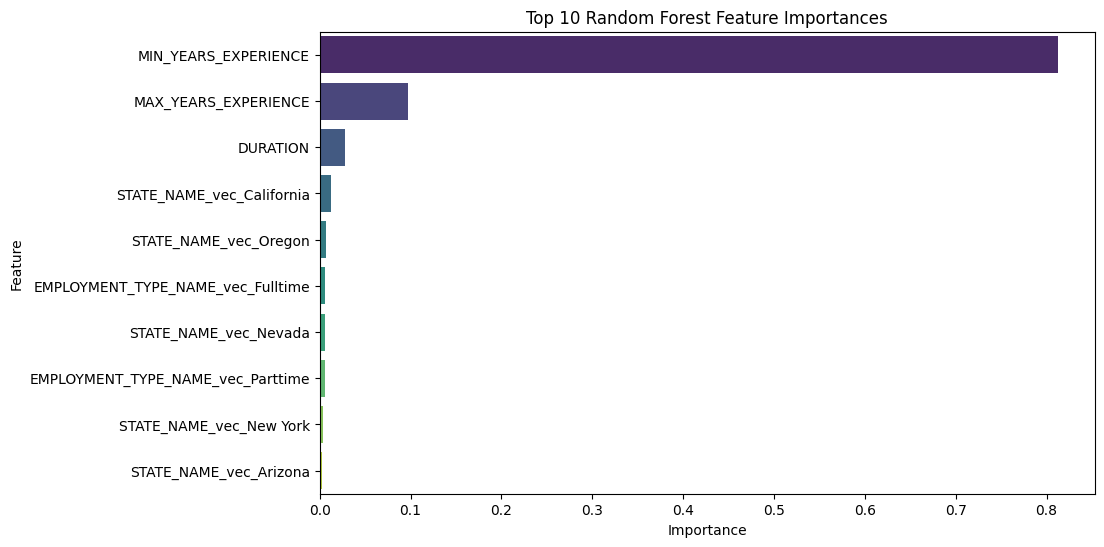

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

importances = np.array(rf_model.featureImportances.toArray())

# Including the same features from the regression model excluding intercept
features = [f for f in features if f.lower() != "intercept"]


feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Top Feature Importances from Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("output/rf_feature_importance.png", dpi=300)
plt.show()

plt.savefig("output/rf_feature_importance.png", dpi=300)

In [55]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Salary", predictionCol="prediction")

rmse_rf = RegressionEvaluator(labelCol="Salary", predictionCol="prediction", metricName="rmse").evaluate(rf_pred)
mae_rf  = RegressionEvaluator(labelCol="Salary", predictionCol="prediction", metricName="mae").evaluate(rf_pred)
r2_rf   = RegressionEvaluator(labelCol="Salary", predictionCol="prediction", metricName="r2").evaluate(rf_pred)

print(f"RF — RMSE: {rmse_rf:.3f} | MAE: {mae_rf:.3f} | R²: {r2_rf:.4f}")

RF — RMSE: 36675.748 | MAE: 27955.463 | R²: 0.3080


Compare 3 Models – GLR, Polynomial, RF
Calculate RMSE, and AIC, BIC, for each model



           Model          RMSE            AIC            BIC
0            GLR  37445.542472  452943.707287   99683.253107
1     Polynomial  36689.249248  565487.442621  498182.708400
2  Random Forest  36675.747872            NaN   99486.708811


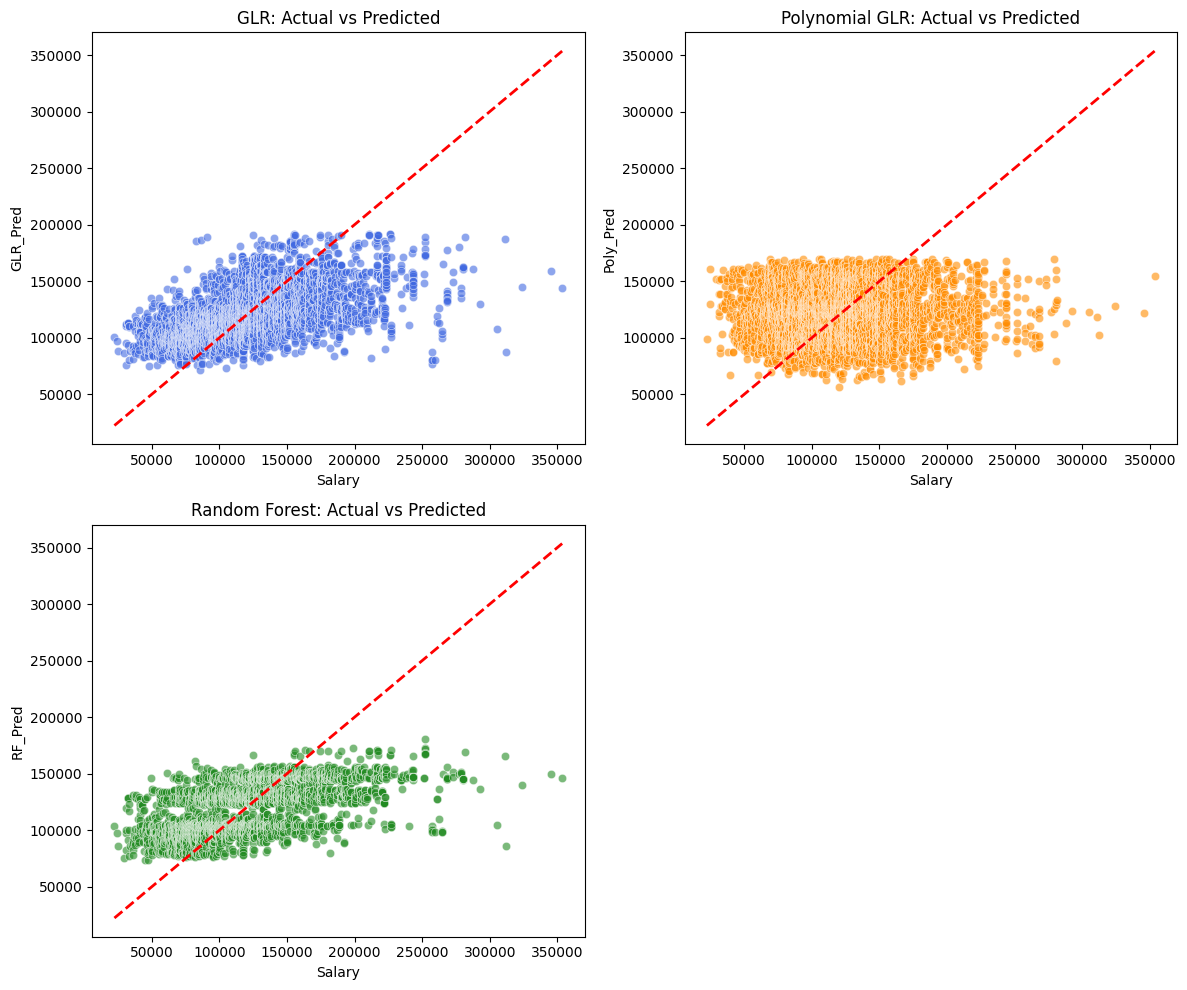

In [59]:
# ---------------------------------------
# 1. Imports
# ---------------------------------------
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# ---------------------------------------
# 2. Make predictions on test data
# ---------------------------------------
glr_pred = glr_model.transform(regression_test)
poly_pred = poly_glr_max_years_model.transform(poly_data)  # or your split poly_test
rf_pred = rf_model.transform(rf_test)

# ---------------------------------------
# 3. Evaluator for RMSE
# ---------------------------------------
evaluator = RegressionEvaluator(
    labelCol="Salary",
    predictionCol="prediction",
    metricName="rmse"
)

glr_rmse = evaluator.evaluate(glr_pred)
poly_rmse = evaluator.evaluate(poly_pred)
rf_rmse = evaluator.evaluate(rf_pred)

# ---------------------------------------
# 4. AIC and BIC
# ---------------------------------------
# AIC is available for GLR summaries only
glr_aic = glr_model.summary.aic
poly_aic = poly_glr_max_years_model.summary.aic

# For BIC, we can approximate:
# BIC = n * ln(RSS/n) + k * ln(n)
# where n = number of samples, k = number of parameters

def calc_bic(df, label_col, pred_col, k):
    pdf = df.select(label_col, pred_col).dropna().toPandas()
    n = len(pdf)
    residuals = pdf[label_col] - pdf[pred_col]
    rss = sum(residuals**2)
    bic = n * math.log(rss/n) + k * math.log(n)
    return bic

# Assume feature length (k) matches number of inputCols
glr_bic = calc_bic(glr_pred, "Salary", "prediction", len(assembler.getInputCols()))
poly_bic = calc_bic(poly_pred, "Salary", "prediction", len(assembler_poly.getInputCols()))
rf_bic = calc_bic(rf_pred, "Salary", "prediction", len(assembler.getInputCols()))

# ---------------------------------------
# 5. Create comparison DataFrame
# ---------------------------------------
metrics_df = pd.DataFrame({
    "Model": ["GLR", "Polynomial", "Random Forest"],
    "RMSE": [glr_rmse, poly_rmse, rf_rmse],
    "AIC": [glr_aic, poly_aic, None],
    "BIC": [glr_bic, poly_bic, rf_bic]
})

print(metrics_df)

# ---------------------------------------
# 6. Merge predictions into Pandas DataFrame
# ---------------------------------------
glr_pd = glr_pred.select("Salary", "prediction").toPandas().rename(columns={"prediction": "GLR_Pred"})
poly_pd = poly_pred.select("Salary", "prediction").toPandas().rename(columns={"prediction": "Poly_Pred"})
rf_pd = rf_pred.select("Salary", "prediction").toPandas().rename(columns={"prediction": "RF_Pred"})

# Combine for plotting
merged = glr_pd.copy()
merged["Poly_Pred"] = poly_pd["Poly_Pred"]
merged["RF_Pred"] = rf_pd["RF_Pred"]

# ---------------------------------------
# 7. Plot 2x2 Grid (Actual vs Predicted)
# ---------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(ax=axes[0,0], data=merged, x="Salary", y="GLR_Pred", alpha=0.6, color="royalblue")
sns.scatterplot(ax=axes[0,1], data=merged, x="Salary", y="Poly_Pred", alpha=0.6, color="darkorange")
sns.scatterplot(ax=axes[1,0], data=merged, x="Salary", y="RF_Pred", alpha=0.6, color="forestgreen")

# Add perfect-fit line
for ax in axes.flat[:-1]:
    ax.plot([merged["Salary"].min(), merged["Salary"].max()],
            [merged["Salary"].min(), merged["Salary"].max()],
            'r--', lw=2)

axes[0,0].set_title("GLR: Actual vs Predicted")
axes[0,1].set_title("Polynomial GLR: Actual vs Predicted")
axes[1,0].set_title("Random Forest: Actual vs Predicted")

# Hide empty 4th subplot
axes[1,1].axis('off')

plt.tight_layout()
plt.savefig("_output/model_comparison_grid.png", dpi=300)
plt.show()